In [1]:
import Metrica_IO as mio
import Metrica_Vizuals as miz
import Metrica_Velocities as mvel
import numpy as np
import pandas as pd
import Metrica_Pitch_Control as mpc
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATA_DIR=r'C:\Users\User\Desktop\FootballAnalysis\sample-data-master'
game_id=2
team_1="Home"
team_2="Away"

#Reading Event & Tracking Data
# StartFrame in event data is sychnronized-aligned with index in tracking data
event=mio.read_event_data(DATA_DIR,game_id)

event=mio.transform_coord_system(event)

tracking_home=mio.read_tracking_data(DATA_DIR,game_id,team_1)
tracking_away=mio.read_tracking_data(DATA_DIR,game_id,team_2)

tracking_away=mio.transform_coord_system(tracking_away)
tracking_home=mio.transform_coord_system(tracking_home)

Reading team: home
Reading team: away


In [3]:
#Reverse directions such that the home team is always attacking from left to right
# DEFAULT COLORS: Home Team: Black, Away Team: Red 
event,tracking_home,tracking_away=mio.set_single_playing_direction(event,tracking_home,tracking_away)

#Calculating Velocities for Home and Away Team
tracking_away=mvel.calc_player_velocities(tracking_away)
tracking_home=mvel.calc_player_velocities(tracking_home)

Calculating velocities for:  Away
Calculating velocities for:  Home


### Get Goalkeepers Names

In [4]:
# Goalkeepers have an advantage to control the ball in their proximity
# because they can use their hands inside the penalty area.
gk_names=[mio.get_goalkeeper_name(tracking_home),mio.get_goalkeeper_name(tracking_away)]
print("Home GK: {}\nAway GK: {}".format(gk_names[0],gk_names[1]))

Home GK: Home_11
Away GK: Away_25


### OFFSIDE

In [5]:
# When player Home_4 Shoots , Player Home_10 is offside
# Save offside movie
miz.save_movie(tracking_home.loc[29700:29850],tracking_away.loc[29700:29850],DATA_DIR+"\movies","Offside",include_player_velocities=True)

Generating movie..
Wait...
Ready


<IPython.core.display.Javascript object>


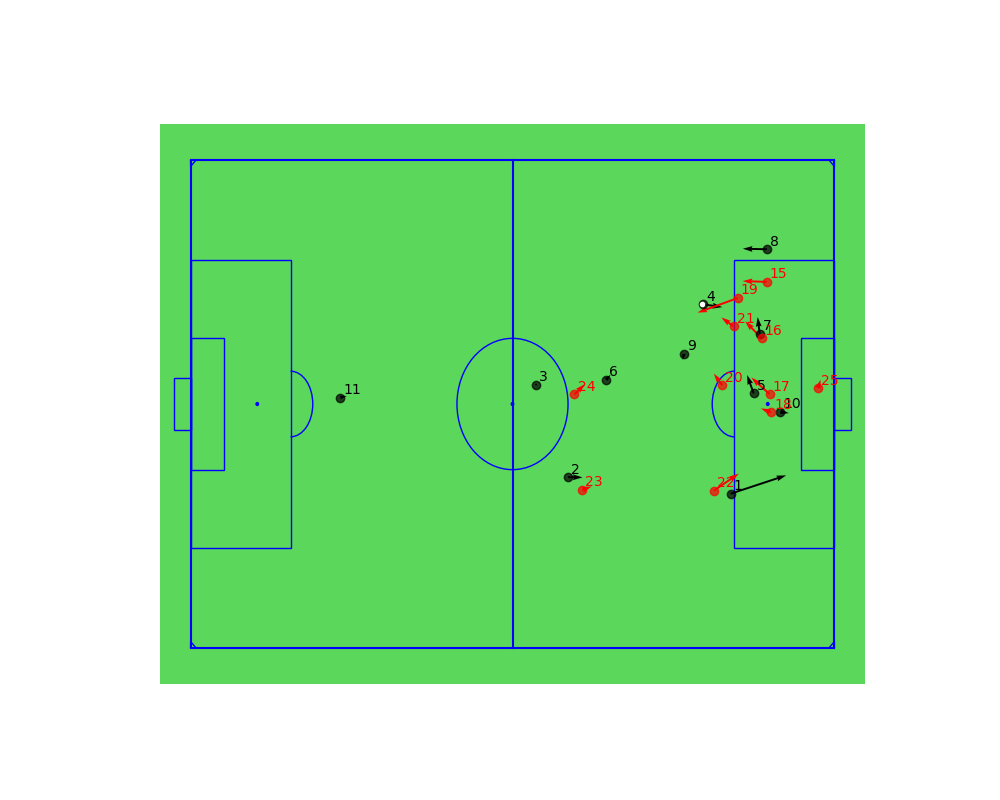

(<Figure size 1000x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xfdba4e0>)

In [6]:
# Use %matplotlib notebook to zoom in 
%matplotlib notebook
# Plot frame to see why Home_10 is offside
miz.plot_frame(tracking_home.loc[29754],
               tracking_away.loc[29754],include_player_velocities=True,
               annotate_player=True) # OFFSIDE

In [7]:
# Example of how "check_offsides works"
import Metrica_Pitch_Control as mpc
params=mpc.get_model_parameters()
attacking_players=mpc.init_players(tracking_home.loc[29754],"Home",params,"Home_11")
defending_players=mpc.init_players(tracking_away.loc[29754],"Away",params,"Away_25")
ball_start_pos=event.loc[472,["Start X","Start Y"]]
non_offside_att_players=mpc.check_offsides("Home",attacking_players,defending_players,ball_start_pos)
print("Number of Non Offside Players: ",len(non_offside_att_players))
# Same for game_id=1 where Away_18 is OFFSIDE
# Event index: 402 , Frame : 29468

Player Home_10 is OFFSIDE!
Number of Non Offside Players:  10


<IPython.core.display.Javascript object>


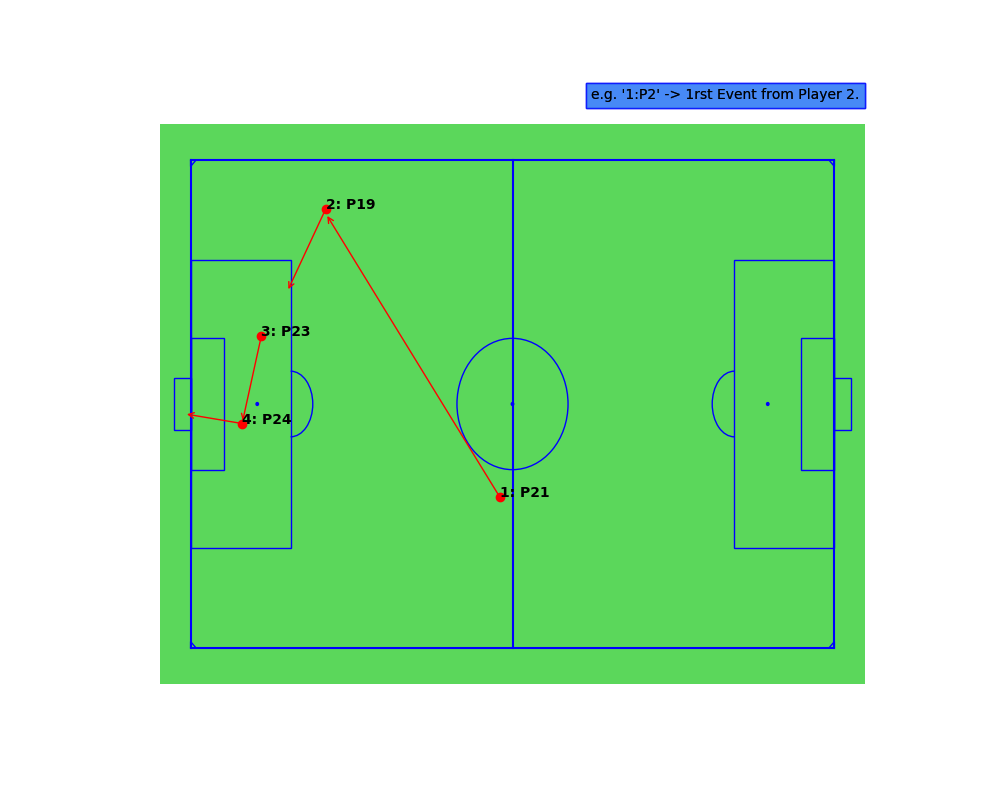

In [9]:
# Passes and shot led to away team's first goal
miz.plot_events(event.loc[820:823],annotate_player=True,annotate_turn=True);

### Pitch Control

<IPython.core.display.Javascript object>


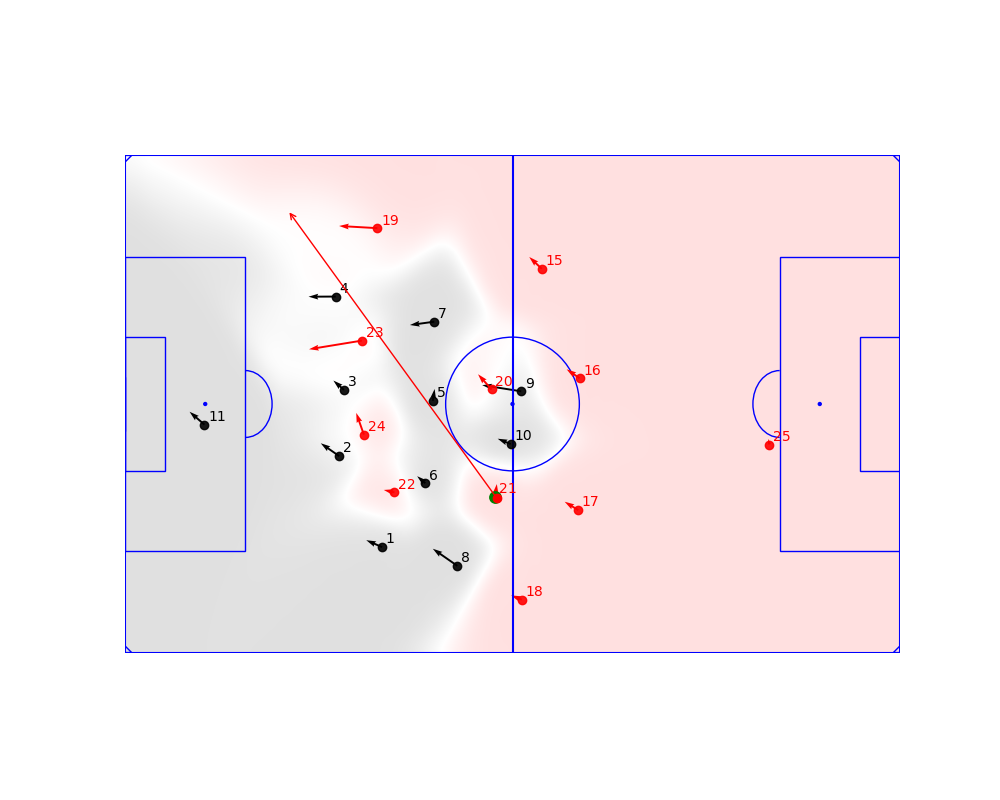

In [11]:
# Get default parameters for pitch control model , such as player_speed, ball_speed, lambda etc.
params=mpc.get_model_parameters()
# Find Pitch Control for first Pass ( Away_21 to Away_19)
pc_attacking,x_grid,y_grid=mpc.find_pitch_control_for_event(820,event,tracking_home,tracking_away,params,gk_names)
miz.plot_pitch_control_for_event(820,event,tracking_home,tracking_away,pc_attacking
                                 ,x_grid,y_grid,annotate_player=True,include_player_velocities=True);

<IPython.core.display.Javascript object>


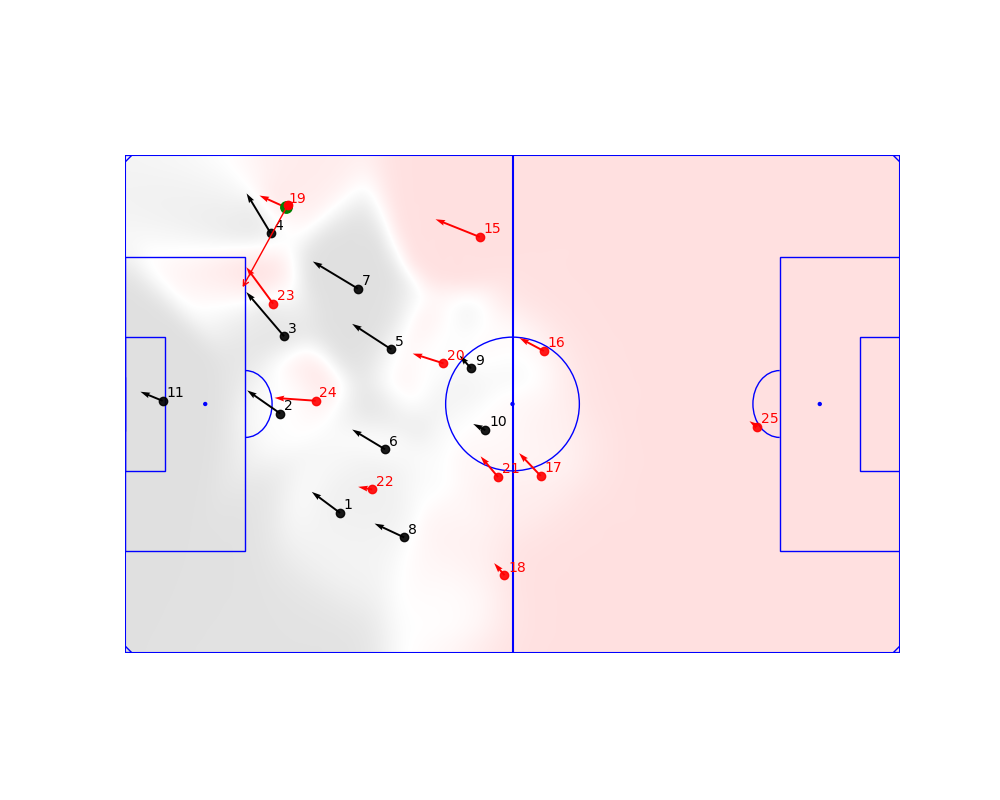

In [12]:
# Find Pitch Control for second Pass ( Away_19 to Away_23)
pc_attacking,x_grid,y_grid=mpc.find_pitch_control_for_event(821,event,tracking_home,tracking_away,params,gk_names)
miz.plot_pitch_control_for_event(821,event,tracking_home,tracking_away,pc_attacking
                                 ,x_grid,y_grid,annotate_player=True,include_player_velocities=True);

<IPython.core.display.Javascript object>


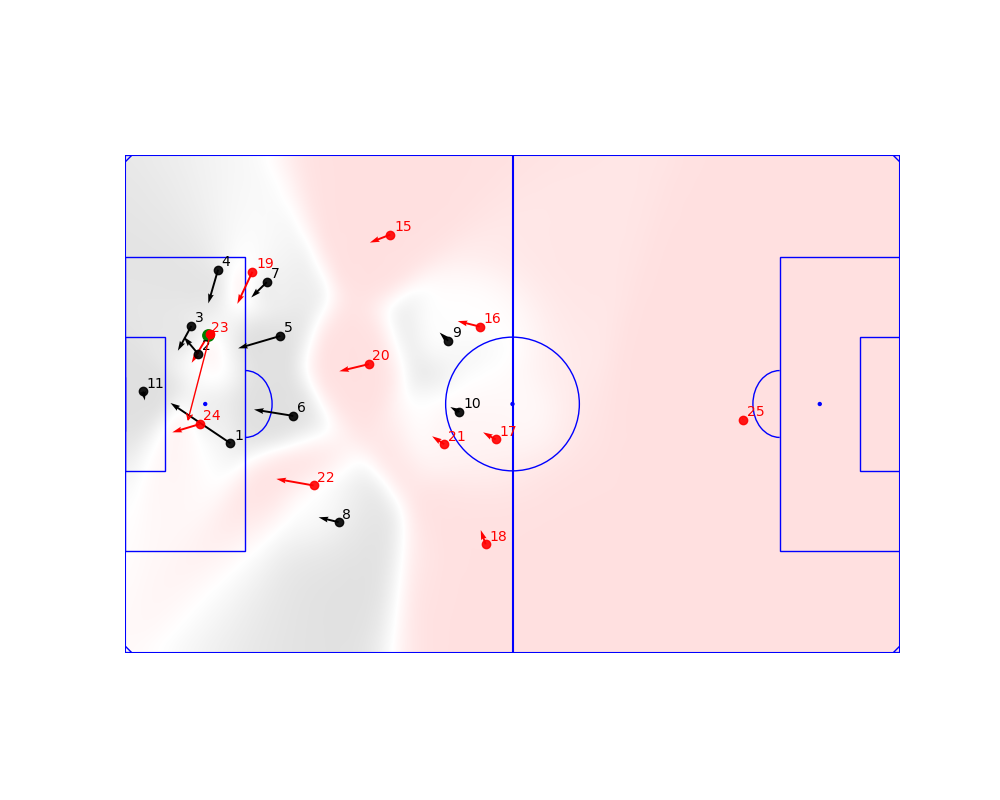

In [14]:
# Find Pitch Control for thrird Pass ( Away_23 to Away_24)
pc_attacking,x_grid,y_grid=mpc.find_pitch_control_for_event(822,event,tracking_home,tracking_away,params,gk_names)
miz.plot_pitch_control_for_event(822,event,tracking_home,tracking_away,pc_attacking
                                 ,x_grid,y_grid,annotate_player=True,include_player_velocities=True);

### Home Passes Success Probability 

In [15]:
# All passes that the home team made (completed, i.e. given Endx,Endy)
home_passes=event[(event["Team"]=="Home") & (event["Type"]=="PASS")]
# Success probability of the passes made.
home_passes_prob=[]

# Find pitch control probability for target_pos= where the ball ended at
# Shows what probability those passes had to be successful
for ind in home_passes.index:
    frame=home_passes.loc[ind,"Start Frame"]
    ball_pos=np.array([home_passes.loc[ind,"Start X"],home_passes.loc[ind,"Start Y"]])
    target_pos=np.array([home_passes.loc[ind,"End X"],home_passes.loc[ind,"End Y"]])
    attacking_players=mpc.init_players(tracking_home.loc[frame],"Home",params,gk_names[0])
    defending_players=mpc.init_players(tracking_away.loc[frame],"Away",params,gk_names[1])
    pc_att,pc_def=mpc.pitch_control_at_pos(target_pos,attacking_players,defending_players,ball_pos,params)
    home_passes_prob.append((ind,pc_att))

We can see that most of the passes (350) made between teammates of the Home Team had really high success probability between 0.9 to 1.0. These of course can be passes made in their own half field and between defenders without much pressing from their opponents 

<IPython.core.display.Javascript object>


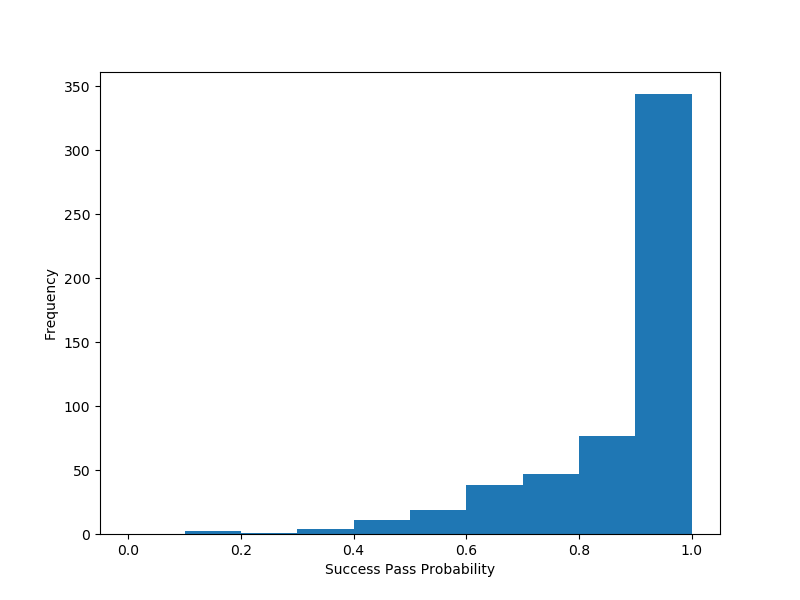

In [17]:
fig=plt.figure(figsize=(8,6))
ax=plt.gca()
ax.hist([pas[1] for pas in home_passes_prob], np.arange(0,1.1,0.1))  
ax.set_xlabel("Success Pass Probability")
ax.set_ylabel("Frequency");

We now plot **risky passes** i.e. passes with less than 0.5 probability of success. It is obvious that the majority of them is long passes. We also print what happened after these passes.

<IPython.core.display.Javascript object>


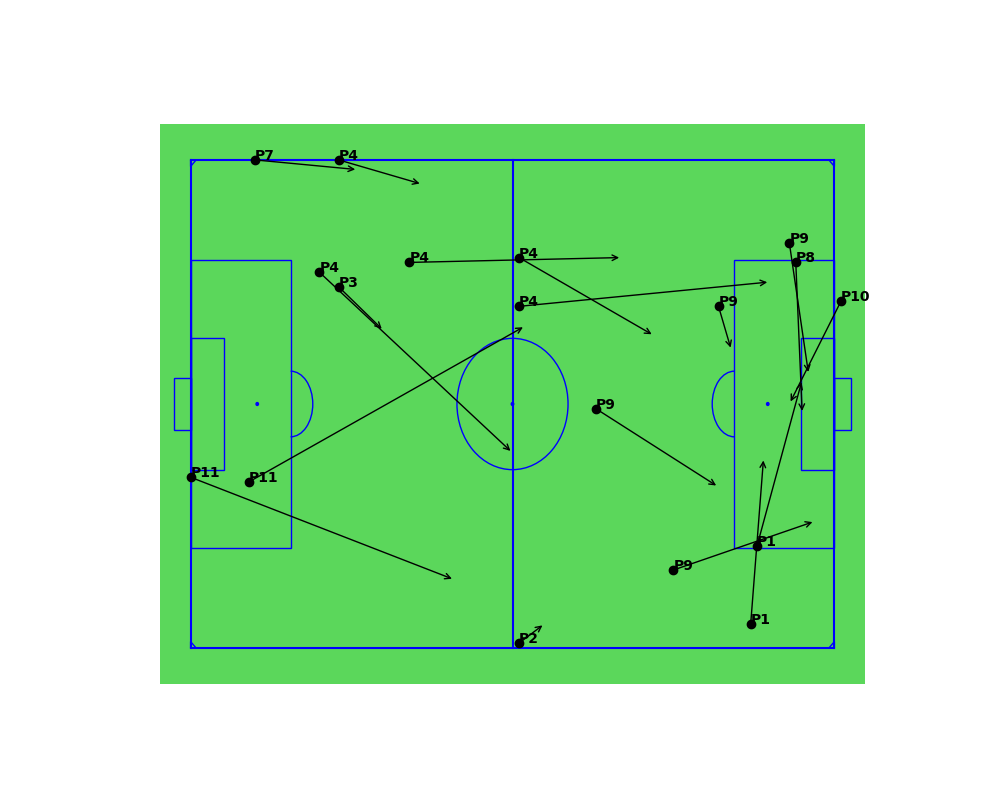

OUTCOME:  CHALLENGE
OUTCOME:  PASS
OUTCOME:  SHOT
OUTCOME:  SHOT
OUTCOME:  BALL LOST
OUTCOME:  CHALLENGE
OUTCOME:  CHALLENGE
OUTCOME:  CHALLENGE
OUTCOME:  CHALLENGE
OUTCOME:  CHALLENGE
OUTCOME:  BALL LOST
OUTCOME:  CHALLENGE
OUTCOME:  CHALLENGE
OUTCOME:  PASS
OUTCOME:  SHOT
OUTCOME:  CHALLENGE
OUTCOME:  SHOT
OUTCOME:  CHALLENGE


In [19]:
#Risky passes
risky_passes=home_passes.loc[[ind for ind,pc in home_passes_prob if pc<0.5] ]

miz.plot_events(risky_passes,annotate_player=True,color='black')

# What happened after risky_passes
for ind in risky_passes.index:
    print("OUTCOME: ",event.loc[ind+1,"Type"])